*First compiled: May 2, 2017. Updated Mar 28, 2018.*

# PAGA for hematopoiesis in mouse [(Paul *et al.*, 2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.0.3 anndata==0.5.8 numpy==1.14.1 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Updating from scikit-learn 0.18 to 0.19.1 changed the implementation of the PCA, hence results look a bit different.

Note: The following function is also available as `sc.datasets.paul15()`.

In [3]:
def paul15():
    import h5py
    filename = 'data/paul15/paul15.h5'
    backup_url = 'http://falexwolf.de/data/paul15.h5'
    sc.utils.check_presence_download(filename, backup_url)
    with h5py.File(filename, 'r') as f:
        X = f['data.debatched'][()]
        gene_names = f['data.debatched_rownames'][()].astype(str)
        cell_names = f['data.debatched_colnames'][()].astype(str)
        clusters = f['cluster.id'][()].flatten()
        infogenes_names = f['info.genes_strings'][()].astype(str)                                                                                                                                
    # each row has to correspond to a sample, therefore transpose                                                                                                                    
    adata = sc.AnnData(X.transpose())
    adata.var_names = gene_names
    adata.row_names = cell_names
    # names reflecting the cell type identifications from the paper                                                                                                                                                                                                                                                    
    cell_type = {7: 'MEP', 8: 'Mk', 9: 'GMP', 10: 'GMP', 11: 'DC',
             12: 'Baso', 13: 'Baso', 14: 'Mo', 15: 'Mo',
             16: 'Neu', 17: 'Neu', 18: 'Eos', 19: 'Lymph'}
    cell_type.update({i: 'Ery' for i in range(1, 7)})
    adata.obs['paul15_clusters'] = [
    str(i) + cell_type[i] for i in clusters.astype(int)]                                                                                                                   
    # make string annotations categorical (optional)                                                                                                                           
    sc.utils.sanitize_anndata(adata)                                                                                                                                                 
    # just keep the first of the two equivalent names per gene                                                                                                                       
    adata.var_names = [gn.split(';')[0] for gn in adata.var_names]                                                                                                       
    # remove 10 corrupted gene names                                                                                                                                                 
    infogenes_names = np.intersect1d(infogenes_names, adata.var_names)                                                                                                               
    # restrict data array to the 3461 informative genes                                                                                                                              
    adata = adata[:, infogenes_names]                                                                                                                                                
    # usually we'd set the root cell to an arbitrary cell in the MEP cluster                                                                                                         
    # adata.uns['iroot': np.flatnonzero(adata.obs['paul15_clusters']  == '7MEP')[0]                                                                                                
    # here, set the root cell as in Haghverdi et al. (2016)                                                                                                                          
    adata.uns['iroot'] = 840  # note that other than in Matlab/R, counting starts at 1
    return adata

In [4]:
adata = paul15()

... storing 'paul15_clusters' as categorical


## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [5]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
    finished (0:00:00.43)


In [6]:
sc.tl.pca(adata)

In [7]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:07.80) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne.png


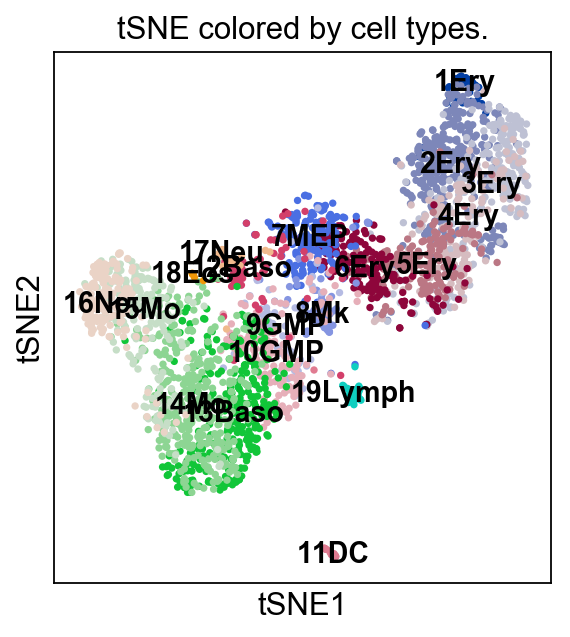

In [8]:
sc.pl.tsne(
    adata, color='paul15_clusters',
    title='tSNE colored by cell types.',
    palette=sc.pl.palettes.default_26,
    legend_loc='on data',
    save=True)

Let us also visualize the data using the Fruchterman-Reingold algorithm.

In [9]:
sc.pp.neighbors(adata, n_neighbors=4)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02.68) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fr"
    finished (0:00:48.09) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obs)


saving figure to file ./figures/draw_graph_fr.png


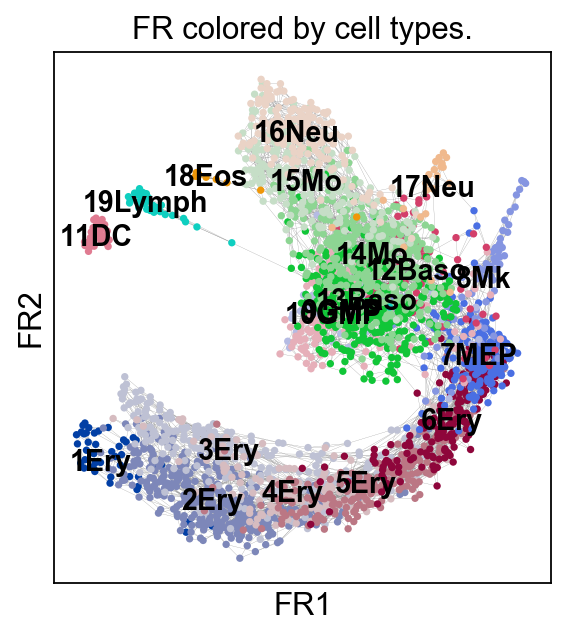

In [10]:
sc.pl.draw_graph(
    adata, color='paul15_clusters',
    title='FR colored by cell types.',
    palette=sc.pl.palettes.default_26,
    legend_loc='on data',
    edges=True,
    save=True)

Apparently, using the default settings, FR resolves the heterogeneity nicer than tSNE.

In [11]:
adata.write(results_file)

## Clustering

In [12]:
adata = sc.read(results_file)

In [13]:
sc.tl.louvain(adata, resolution=1.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.16) --> found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Annotate the clusters using the reference labels.

In [15]:
import re
asso_names, _ = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='louvain', reference='paul15_clusters',
    normalization='reference', max_n_names=1)
adata.obs['louvain'].cat.categories = [
    '{}/{}'.format(name, re.sub('\d+', '', asso_names[iname]))  # replace integers
     for iname, name in enumerate(adata.obs['louvain'].cat.categories)]

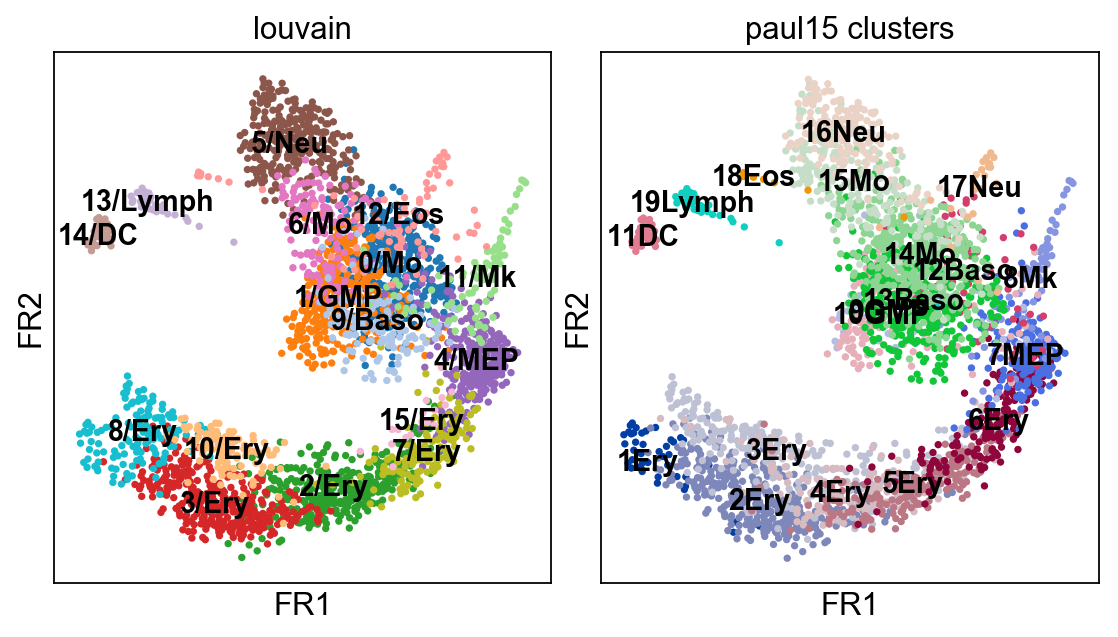

In [17]:
sc.pl.draw_graph(adata, color=['louvain', 'paul15_clusters'], legend_loc='on data')

## PAGA

In [18]:
sc.tl.paga(adata)

running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:00.07) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


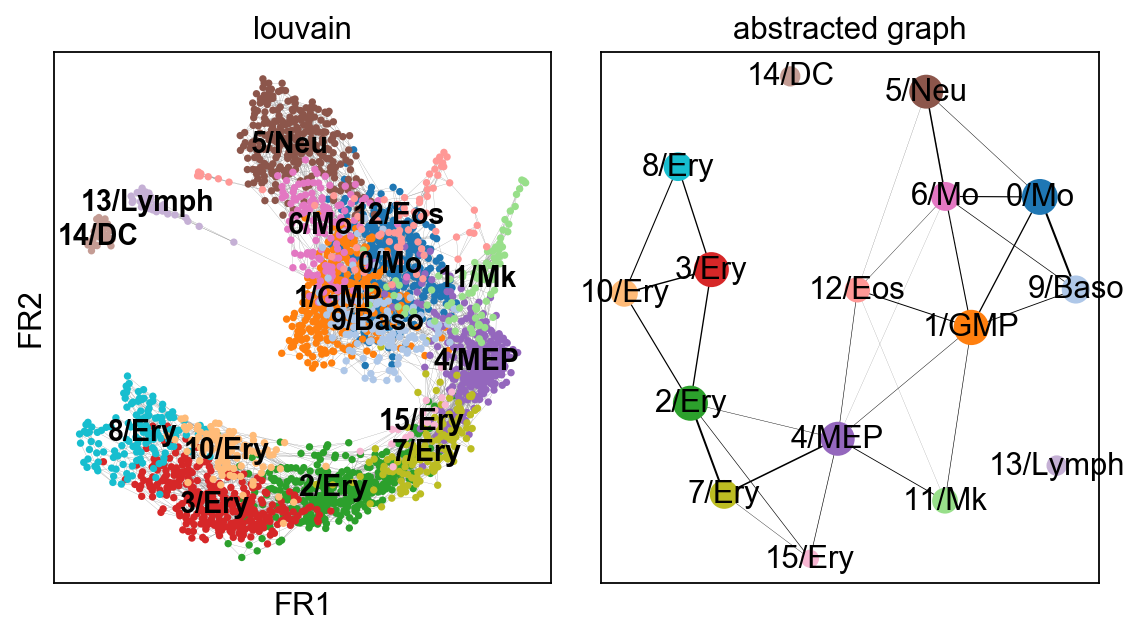

In [20]:
sc.pl.paga_compare(
    adata, basis='draw_graph_fr', layout='fr', threshold_solid=0.005)

In [21]:
adata.write(results_file)

## Reconstruct gene changes along PAGA paths for a given set of genes

In [22]:
adata = sc.read(results_file)

In [23]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['paul15_clusters']  == '7MEP')[0]

In [24]:
sc.tl.dpt(adata)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.         1.         0.9973023  0.9965848  0.9871867  0.98162997
     0.9783714  0.9779262  0.97391486 0.9680968 ]
    finished (0:00:00.10) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


In [25]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

Use the full raw data for visualization.

In [26]:
adata_raw = paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical


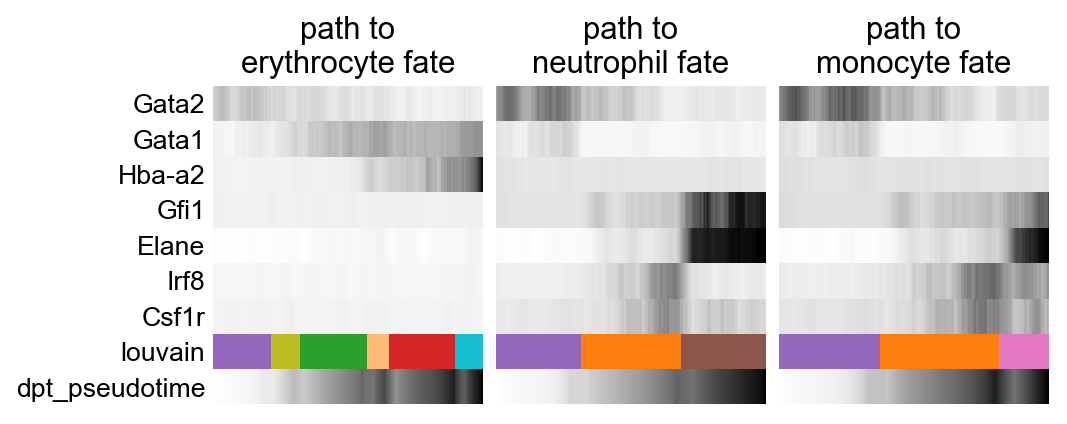

In [28]:
paths = [('erythrocytes', [4, 7, 2, 10, 3, 8]),  # use the category indices instead of the cluster names
         ('neutrophils', [4, 1, 5]), 
         ('monocytes', [4, 1, 6])]

_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',                             
        title='path to\n{} fate'.format(descr[:-1]),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path.png')
pl.show()